Mounted at /content/drive
Train shape: (16401, 41) (16401,)
Test shape: (4030, 41) (4030,)
RMSE: 34.170436266822996
MAE: 24.39674193548387
R2 Score: 0.7247778743625928


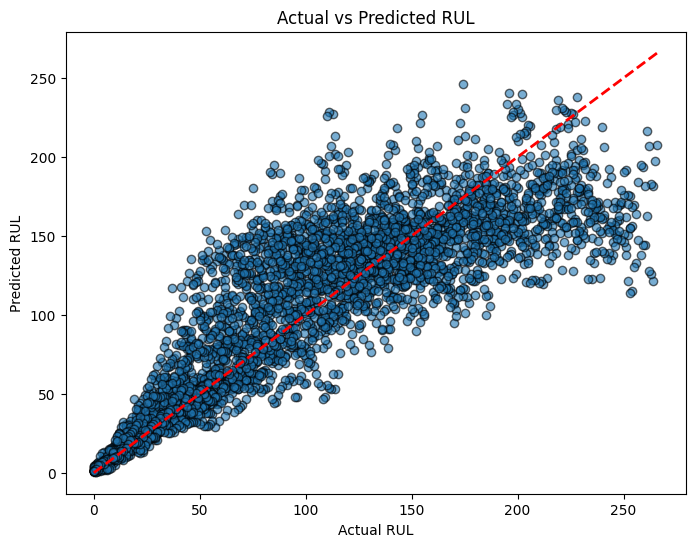

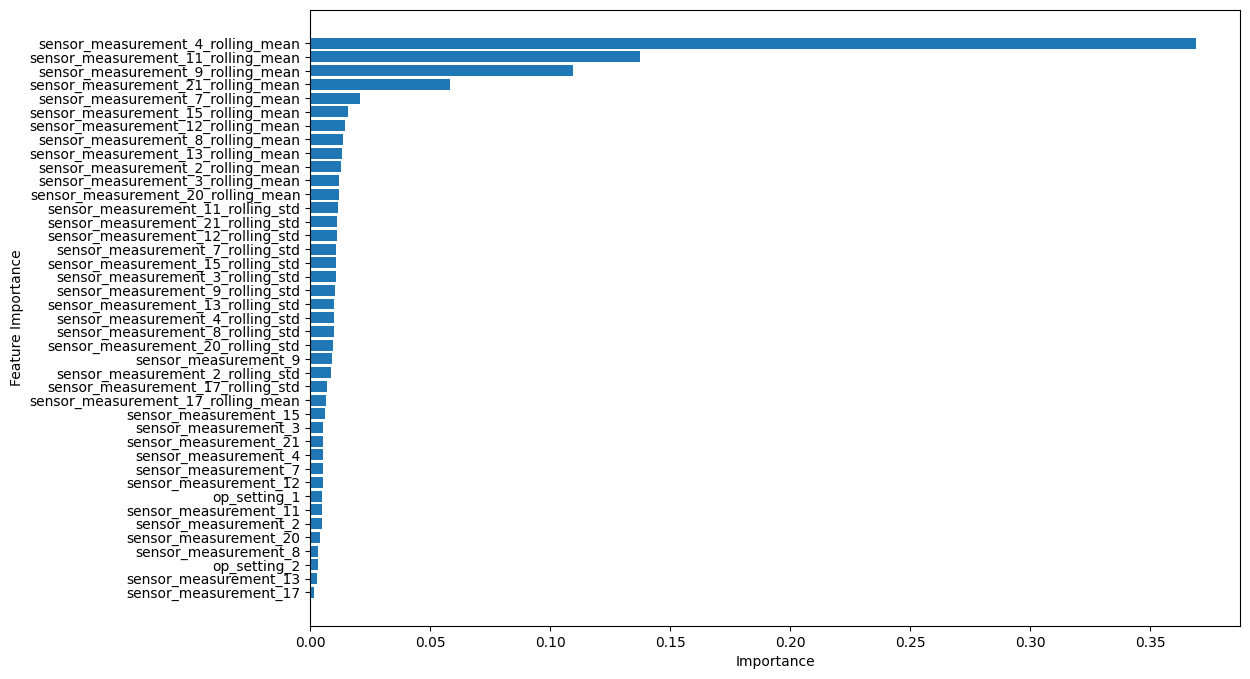

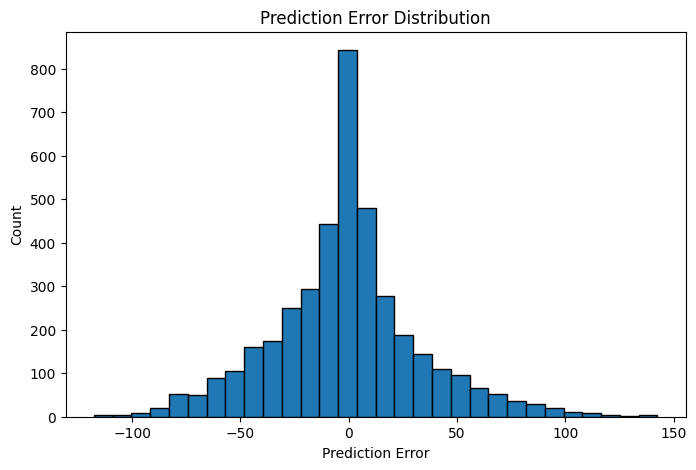

Baseline RF Model saved
Data saved to: /content/drive/MyDrive/predictive_maintenance/processed_data_Baseline_rf_model.csv


In [ ]:
### --------------------------------------------------------------------------- ###
# --- Basline Random Forest
### --------------------------------------------------------------------------- ###


# --- 1. Imports ---
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create a path for results or plots to be saved as PNG
if not os.path.exists('../results'):
    os.makedirs('../results')
# --- 2. Load & process Data ---
file_path = "/content/drive/MyDrive/predictive_maintenance/processed_train_FD001.csv"
df = pd.read_csv(file_path)

# Handle missing values before train/test split
df = df.fillna(0)   # this line will help in ensuring dataset had no NaNs or infinite values (if not used in code, chances of breaking the ML model occur)
df = df.replace([np.inf, -np.inf], 0)   # handle any infinite values

# ------------------------------------------ #
# --- 2. Define the features and target ---
# ------------------------------------------ #
final_features = [col for col in df.columns if 'sensor_measurement' in col or 'op_setting' in col]
X = df[final_features]  #target
y = df['RUL']

# check shapes
'''print("Featues shape:" , X.shape)
print("Target shape:" , y.shape)
print("X.head():" , X.head())
print("y.head():", y.head())'''

# --------------------------------------------- #
# --- 3. Train/Test Split ---   (purpose of split i found is that splitting data intp train & test data helps in avoiding datac leakage and ensures the model is evaluated fairly)
# --------------------------------------------- #
# Get unique engines
engines = df['unit_number'].unique()

# Split engines into train/test
train_engines, test_engines = train_test_split(engines, test_size=0.2,random_state=42)

# Filter dataset for train/test   (filter to separate training test datasets)
train_df = df[df['unit_number'].isin(train_engines)]
test_df = df[df['unit_number'].isin(test_engines)]

# Separate features/target for model
X_train = train_df[final_features]
y_train = train_df['RUL']
X_test = test_df[final_features]
y_test = test_df['RUL']

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

# ---------------------------------------------------- #
# --- 4. Train a baseline Random Forest ML model ---
# (We train RandomForest model here because it's interpretable and handles complex patterns, there are much accurate models than this model we'll be analysing after)
# ---------------------------------------------------- #
# let initialize the model
rf_model = RandomForestRegressor(
    n_estimators = 100, #number of trees
    random_state=42 ,   # reproducibility
    n_jobs=-1  # use all CPU cores
)

# To Fit the model --> means model will learn patterns from the your data
rf_model.fit(X_train,y_train)

# predictions on test data
y_pred = rf_model.predict(X_test)

# --------------------------------------------------------- #
# --- 5. Model Evaluation ---
# --------------------------------------------------------- #
# RMSE = Root Mean Squared Error
#   - Measures the average size of errors, giving higher weight to large mistakes
#   - Lower RMSE means better accuracy
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

# MAE = Mean Absolute Error
#   - Average absolute difference between predicted RUL and actual RUL
#   - Lower MAE means predictions are closer to actual values
mae = mean_absolute_error(y_test,y_pred)

# R² Score (Coefficient of Determination)
#   - Measures how much variance in the target (RUL) the model explains
#   - R² = 1 means perfect predictions, R² = 0 means no better than average
r2 = r2_score(y_test,y_pred)

print("RMSE:" , rmse)
print("MAE:" , mae)
print("R2 Score:" , r2)

# -------------------------------------------------------------- #
# --- 6. Visualizations ---
# -------------------------------------------------------------- #
# Plot Actual vs Predicted RUL
plt.figure(figsize = (8,6))
plt.scatter(y_test,y_pred, alpha = 0.6 , edgecolors = 'k')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(),y_test.max()],
         'r--' , lw =2)
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL')
plt.show()

# ---------------------------------------------------------------- #
# --- 7. Feature Importance Analysis & Error Calculation ---
# ---------------------------------------------------------------- #

importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature' : final_features,
    'importance' : importances
}).sort_values(by= 'importance', ascending = False)

plt.figure(figsize=(12,8))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.ylabel('Feature Importance')
plt.show()


# Error Distribution Plot
errors = y_test - y_pred
plt.figure(figsize=(8,5))
plt.hist(errors,bins=30, edgecolor = 'k')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()

# ------------------------------------------------------------- #
# --- 8. Save the Baseline Model ---
# ------------------------------------------------------------- #

# Save the data to drive for next analysis
output_path = "/content/drive/MyDrive/predictive_maintenance/processed_data_Baseline_rf_model.csv"
df.to_csv(output_path, index=False)

print("Baseline RF Model saved")
print(f"Data saved to: {output_path}")

# Save as .pkl
import joblib
joblib.dump(rf_model, 'baseline_rf_model.pkl')
loaded_rf = joblib.load('baseline_rf_model.pkl')  # Later, we can load this trained data without retraining.

# ============================================================== #
# Summary

# In today's study, we tried to train a baseline Random Forest model (group of Decision Trees) to predict RUL of engines.
# After training the model we split the engines into train/test to evaluate performance realistically and avoid data leakage.
# Checked predictions and visualized them, also checked feature importance, and erros to understand model behaviour.  (this information for predictions was optional for project problem statement but found useful from the references i studied.)

# =============================================================== #